# Classification on banana data set
In this notebook, we show how to use `SFR` for classification on the banana data set.

In [1]:
from IPython.display import clear_output

import src
import numpy as np
import torch 
import matplotlib.pyplot as plt
import matplotlib
from src.custom_types import Data

Let's fix the random seed for reproducibility and set the default type to float64.

In [2]:
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

## Banana data set

The banana data set is a binary classification problem with inputs $\mathbf{x}_i \in \mathbb{R}^2$ and outputs ${y}_i \in \{0, 1\}$. 
We assume that an output ${y}_i$ is generated from a Bernoulli trial,
$$
y_i \sim \text{Bernoulli}(\Phi(f_{\mathbf{w}}(\mathbf{x}_i))) \\
$$
where the corresponding input $\mathbf{x}_i$ is mapped through a latent function $f : \mathbb{R}^2 \rightarrow \mathbb{R}$ and the Gaussian cumulative distribution function  $\Phi(\cdot)$ to obtain a value $\Phi(f_{\mathbf{w}}(\mathbf{x}_i)) \in [0, 1]$ which can be interpreted as a probability.

Let's load the Banana data set and visualise it.

In [3]:
X = np.loadtxt("./data/banana_X_train", delimiter=",")
Y = np.loadtxt("./data/banana_Y_train")[:, None]
X_train = torch.from_numpy(X)
Y_train = torch.from_numpy(Y)
data = (X_train, Y_train)

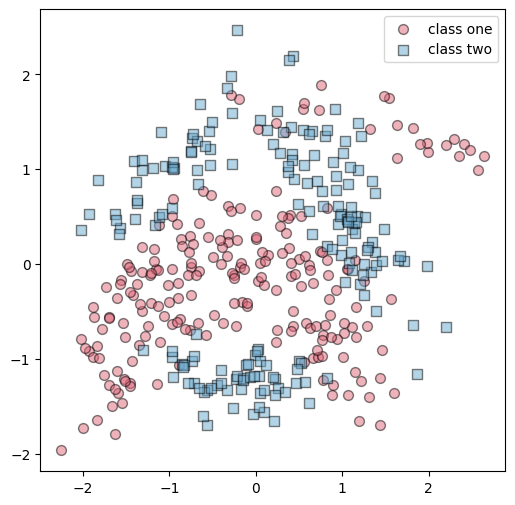

In [4]:
C1=f"#69a9ce"
C0=f"#df6679"
limits = [-2.8, 2.8, -2.8, 2.8]
xtest, ytest = np.mgrid[limits[0] : limits[1] : 100j, limits[2] : limits[3] : 100j]
Xtest = np.vstack((xtest.flatten(), ytest.flatten())).T
X_test = torch.from_numpy(Xtest)

    
def plot_data(fig, ax):
    if data is not None:
        X, Y = data
        for i, mark, c, label in [[1, "o", C0, "class one"], [0, "s", C1, "class two"]]:
            ind = Y[:, 0] == i
            ax.scatter(
                X[ind, 0],
                X[ind, 1],
                s=50,
                alpha=0.5,
                edgecolor="k",
                marker=mark,
                color=c,
                label=label,
            )
    ax.legend()
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_data(fig, ax)

## Neural network 

Given the data set $\mathcal{D} = \{(\mathbf{x}_{i} , \mathbf{y}_{i})\}_{i=1}^{N}$, we want to approximate the function $f$ with a neural network $f_\mathbf{w}: \mathbb{R} \to \mathbb{R}$ with weights $\mathbf{w} \in \mathbb{R}^{P}$.
It is common to traing the neural network weights $\mathbf{w}$ to minimize the (regularized) empirical risk,
\begin{equation}
  \mathbf{w}^{*} = 
  \arg \min_{\mathbf{w}} \mathcal{L}(\mathcal{D},\mathbf{w}) =
  \arg \min_{\mathbf{w}} \textstyle\sum_{i=1}^{N} \ell(f_\mathbf{w}(\mathbf{x}_{i}), y_i) + \delta \mathcal{R}(\mathbf{w}).
\end{equation}
where $l(f_\mathbf{w}(\mathbf{x}_{i}), y_i) = -\log(p(y \mid f_\mathbf{w}(\mathbf{x}_{i}))$ and the regularizer $\mathcal{R}(\mathbf{w}) = \frac{1}{2}\| \mathbf{w}\|^{2}_{2}$.
We can view this as the maximum a~posteriori (MAP) solution to a Bayesian objective, where the first term $l(f_\mathbf{w}(\mathbf{x}_{i}), y_i)$ represents the log likelihood and the regularization weight takes the role of a prior precision parameter, $p(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \delta^{-1} \mathbf{I})$.

Let's start by creating a neural network.

In [5]:
width = 64

network = torch.nn.Sequential(
    torch.nn.Linear(2, width),
    torch.nn.Sigmoid(),
    torch.nn.Linear(width, width),
    torch.nn.Sigmoid(),
    torch.nn.Linear(width, 1),
)

Making predictions with `SFR` depends on the loss function as it encodes our likelihood and prior.
As such, we instantiate `SFR` by passing it a prior and a likelihood.

We use a Gaussian prior over the weights as it correspondes to a weight decay regulariser.

In [6]:
delta = 0.0002

prior = src.priors.Gaussian(params=network.parameters, delta=delta)

We use a Bernoulli likelihood, which corresponds to using the binary cross entropy loss.

In [7]:
likelihood = src.likelihoods.BernoulliLh(EPS=0.01)

In [8]:
sfr = src.sfr.SFR(
    network=network,
    prior=prior,
    likelihood=likelihood,
    output_dim=1,
    num_inducing=45,
    dual_batch_size=None, # this reduces the memory required for computing dual parameters
    jitter=1e-4,
)

We can now train the network using our loss function `SFR.loss()`.

In [9]:
num_epochs = 2500
batch_size = X_train.shape[0]
learning_rate = 1e-2

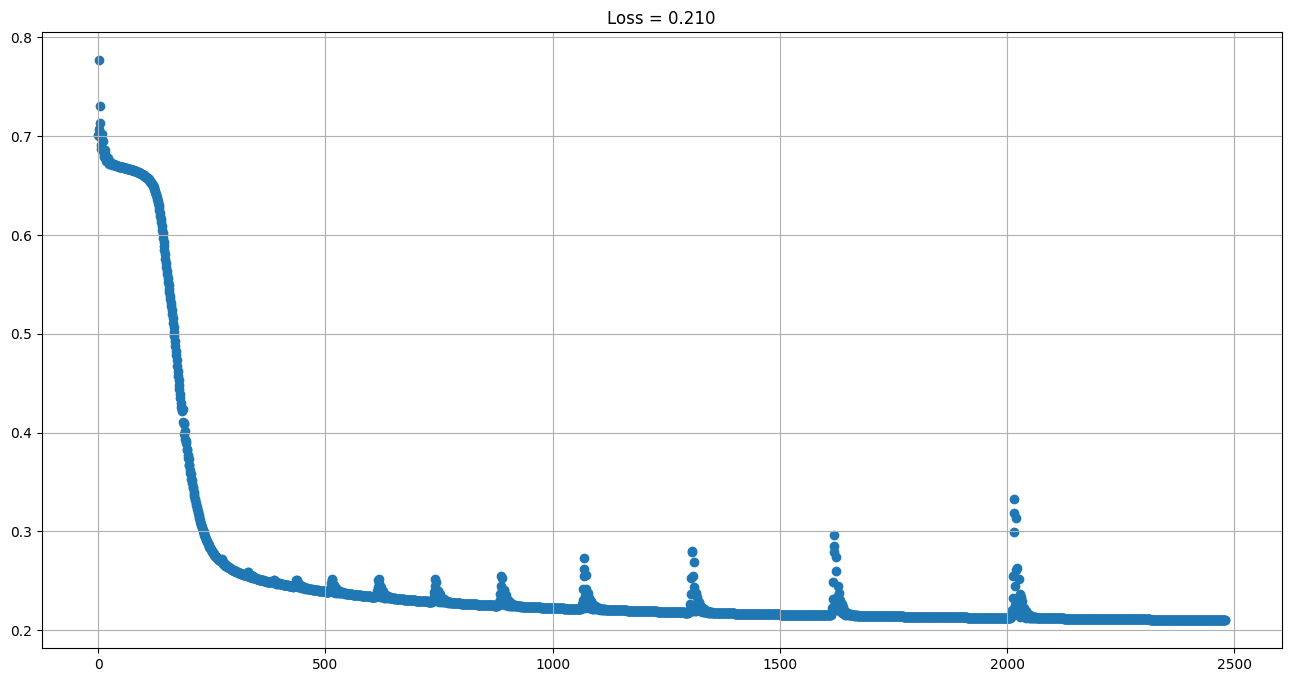

In [10]:
def train(
    sfr: src.SFR,
    data: Data,
    num_epochs: int = 1000,
    batch_size: int = 16,
    learning_rate: float = 1e-3,
) -> dict:
    data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*data), batch_size=batch_size)
    sfr.train()
    optimizer = torch.optim.Adam([{"params": sfr.parameters()}], lr=learning_rate)
    loss_history = []
    for epoch_idx in range(num_epochs):
        for batch_idx, batch in enumerate(data_loader):
            x, y = batch
            loss = sfr.loss(x, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_history.append(loss.detach().numpy())
            
        if epoch_idx % 20 == 0:
            clear_output(True)
            plt.figure(figsize=[16, 8])
            plt.subplot()
            plt.title("Loss = %.3f" % np.mean(loss_history[-32:]))
            losses = np.array(loss_history)
            losses_idx = np.arange(len(losses))
            plt.scatter(losses_idx, losses)
            plt.grid()
            plt.show()

    return {"loss": loss_history}

metrics = train(sfr=sfr, data=data, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)

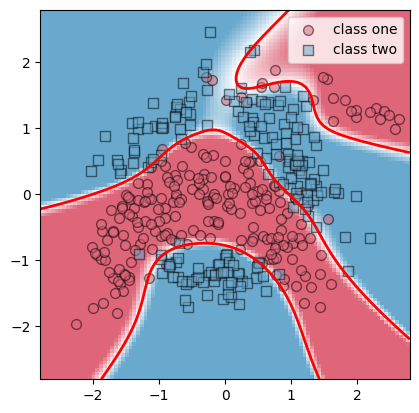

In [11]:
cmap_nn = matplotlib.colors.LinearSegmentedColormap.from_list("", [C1, "white", C0])

def plot_nn(fig, ax):
    X_test = torch.from_numpy(Xtest)
    y_net = network(X_test).detach().numpy()
    ax.contour(xtest,
               ytest,
               y_net.reshape(*xtest.shape),
               levels=[0.0],
               colors="r",
               linewidths=2.0,
            )
    ax.imshow(y_net.reshape(*xtest.shape).transpose(),
              extent=limits,
              origin="lower",
              cmap=cmap_nn,
              vmin=-1,
              vmax=1,
            )
    plot_data(fig, ax)
    ax.legend()


fig, ax = plt.subplots()
plot_nn(fig, ax)

## Inference

Now that we have a trained neural network, we can use `src.SFR` to build our sparse GP model.
That is, we perform inference by calculating the dual variables.

To perform inference `src.SFR` first calculates the dual parameters at each data point.
It then samples a set of inducing points from the inputs and projects the dual parameters onto them.
This is done with  `sfr.set_data(data)`.

In [12]:
sfr.set_data(data)

INFO:src.sfr:Calculating dual params and building prediction fn...
INFO:src.sfr:Finished calculating dual params
INFO:src.sfr:Finished building predict fn


We can now make predictions using our GP.

In [13]:
y_mu, y_var = sfr.predict(X_test)

y_mu = y_mu.numpy()
y_var = y_var.numpy()

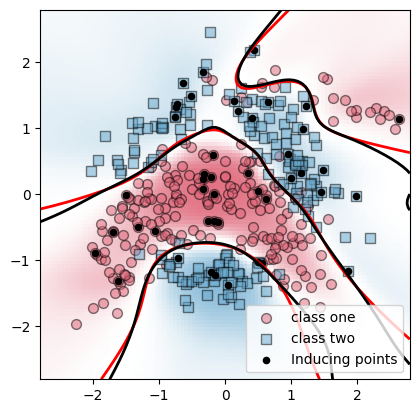

In [14]:
cmap0 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", C1])
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", [C0, "white"])

colors0 = cmap0(np.linspace(0, 1.0, 128))
colors1 = cmap1(np.linspace(0, 1.0, 128))
colors = np.append(colors0, colors1, axis=0)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

def plot_gp(fig, ax):
    X_test = torch.from_numpy(Xtest)
    y_net = network(X_test).detach().numpy()
    # Scale background
    foo = y_mu > 0.5
    foo = foo.astype(float)
    foo = (2.0 * foo - 1.0) * np.sqrt(y_var)
    vmax = np.max(np.sqrt(y_var))
    ax.imshow(
            foo.reshape(*xtest.shape).transpose(),
            extent=limits,
            origin="lower",
            cmap=cmap,
            vmin=-vmax,
            vmax=vmax,
        )
    ax.contour(
            xtest,
            ytest,
            y_mu.reshape(*xtest.shape),
            levels=[0.5],
            colors="k",
            linewidths=2.0,
        )
    ax.scatter(sfr.Z.numpy()[:, 0], sfr.Z.numpy()[:, 1], s=20, color="k", label="Inducing points")
    ax.legend()



fig, ax = plt.subplots()
plot_nn(fig, ax)
plot_gp(fig, ax)